In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
!pip install unrar

In [ ]:
!unrar x potato.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from potato.rar

Creating    potato                                                    OK
Creating    potato/Potato___Early_blight                              OK
Extracting  potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG       0%  OK 
Extracting  potato/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG       0%  OK 
Extracting  potato/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG       0%  OK 
Extracting  potato/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG       0%  OK 
Extracting  potato/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG       0%  OK 
Extracting  potato/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG       0%  OK 
Extracting  

In [ ]:
!unzip potato.rar

Archive:  potato.rar
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of potato.rar or
        potato.rar.zip, and cannot find potato.rar.ZIP, period.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/potato')

In [ ]:
IMAGE_SIZE= 256
BATCH_SIZE= 32
CHANNELS=3
EPOCHS=50

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

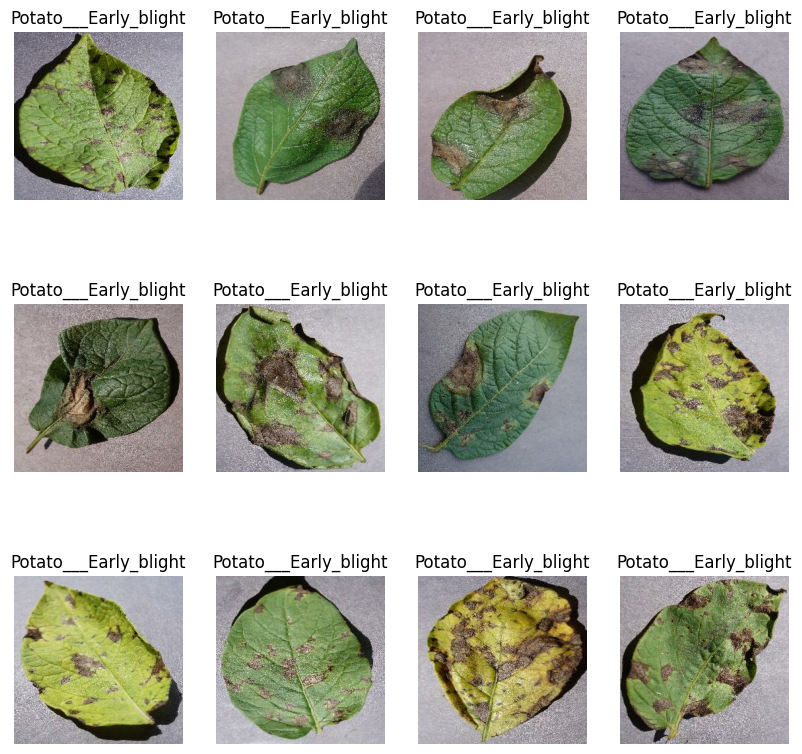

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [ ]:
80% ==> training
10% ==> validation
10% ==> test

In [ ]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds=dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)

  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 16s 109ms/step - loss: 0.9150 - accuracy: 0.4890 - val_loss: 0.9292 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 6s 110ms/step - loss: 0.7404 - accuracy: 0.6800 - val_loss: 0.6525 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 6s 103ms/step - loss: 0.5574 - accuracy: 0.7679 - val_loss: 0.4391 - val_accuracy: 0.8095
Epoch 4/50
54/54 [==============================] - 5s 100ms/step - loss: 0.3984 - accuracy: 0.8409 - val_loss: 0.3774 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 8s 155ms/step - loss: 0.3095 - accuracy: 0.8704 - val_loss: 0.3263 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 5s 97ms/step - loss: 0.2708 - accuracy: 0.8918 - val_loss: 0.3344 - val_accuracy: 0.8333
Epoch 7/50
54/54 [==============================] - 9s 160ms/step - loss: 0.2185 - accuracy: 0.9138 - val_loss: 0.1565 - val_accuracy: 0.9427
Epoch 

In [ ]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 28ms/step - loss: 0.0622 - accuracy: 0.9805


In [ ]:
scores

[0.06221483647823334, 0.98046875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.48900464177131653,
 0.6799768805503845,
 0.7679398059844971,
 0.8408564925193787,
 0.8703703880310059,
 0.8917824029922485,
 0.9137731194496155,
 0.9236111044883728,
 0.9108796119689941,
 0.9305555820465088,
 0.9513888955116272,
 0.9594907164573669,
 0.9635416865348816,
 0.9797453880310059,
 0.9594907164573669,
 0.9820601940155029,
 0.9797453880310059,
 0.9774305820465088,
 0.9739583134651184,
 0.9751157164573669,
 0.9745370149612427,
 0.9774305820465088,
 0.9872685074806213,
 0.9872685074806213,
 0.9826388955116272,
 0.9855324029922485,
 0.9797453880310059,
 0.9733796119689941,
 0.9745370149612427,
 0.9820601940155029,
 0.9895833134651184,
 0.9901620149612427,
 0.9826388955116272,
 0.9866898059844971,
 0.9832175970077515,
 0.9832175970077515,
 0.9913194179534912,
 0.9918981194496155,
 0.984375,
 0.9814814925193787,
 0.9866898059844971,
 0.9913194179534912,
 0.9907407164573669,
 0.9936342835426331,
 0.9820601940155029,
 0.9953703880310059,
 0.9884259104728699,
 0.9855324029922485,
 

In [ ]:
len(history.history['accuracy'])

50

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

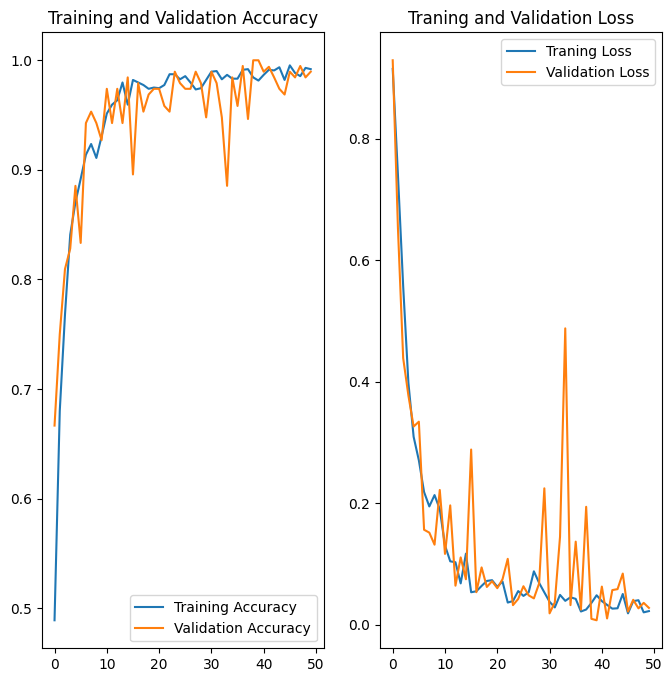

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Traning Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Traning and Validation Loss')
plt.show()

In [ ]:
np.argmax([9.9999964e-01,3.9333537e-07,1.15896251e-18])

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 237ms/step
predicted label: Potato___healthy


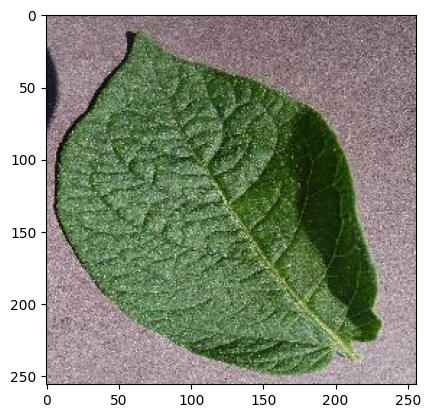

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("my_model")

In [ ]:
from google.colab import files
files.download("my_model")


In [ ]:
from google.colab import files
files.download('my_model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>